In [1]:
rm(list=ls())
library(car)
library(leaps)
setwd("D:/2019 Fall/STAT 628/module 2")
data = read.csv("data.cleaned.csv")[,-1]

Loading required package: carData
Loading required package: leaps


### Review of original linear regression model


Call:
lm(formula = BODYFAT ~ ., data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.5071 -2.8500 -0.0758  2.6625  8.9777 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -15.39482   36.88142  -0.417  0.67676    
AGE           0.06421    0.03010   2.133  0.03394 *  
WEIGHT       -0.07018    0.10258  -0.684  0.49460    
HEIGHT        0.14148    0.50393   0.281  0.77915    
ADIPOSITY     0.56677    0.71543   0.792  0.42905    
NECK         -0.36402    0.21413  -1.700  0.09047 .  
CHEST        -0.14171    0.10174  -1.393  0.16499    
ABDOMEN       0.82293    0.08508   9.673  < 2e-16 ***
HIP          -0.18374    0.13529  -1.358  0.17574    
THIGH         0.18006    0.13518   1.332  0.18417    
KNEE         -0.06110    0.22621  -0.270  0.78732    
ANKLE        -0.02611    0.24870  -0.105  0.91648    
BICEPS        0.14030    0.15633   0.897  0.37040    
FOREARM       0.24756    0.19004   1.303  0.19398    
WRIST        -1.60865    0.49603  -

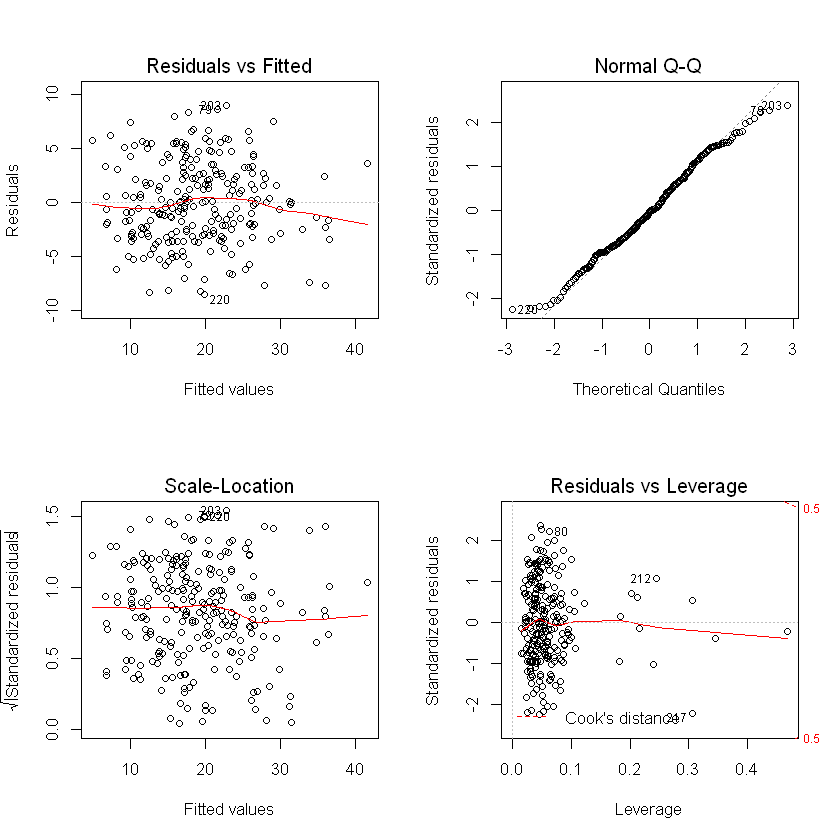

In [2]:
m = lm(BODYFAT~.,data)
summary(m)
par(mfrow=c(2,2))
plot(m)

From the summary of the model, it can be seen that there exists some insignificant predictors;

Besides, we will show there is multi-colinearity relationship between design matrix.

#### Colinearity in design matrix

In [3]:
cat("The maximum vif value of design matrix X is: ",max(vif(m)),sep="")
mat = as.matrix(data[-1])
cat("\n The k condition number of design matrix X is: ",max(eigen(t(mat)%*%mat)$values)/min(eigen(t(mat)%*%mat)$values),sep="")

The maximum vif value of design matrix X is: 123.7778
 The k condition number of design matrix X is: 347590.7

Thus, for computational efficiency and multi-colinearity solution, apply step-wise regression with different directions and criteria ti do variables selection.

### Variable selection

In [5]:
n = nrow(data)
set.seed(628)
index = sample(1:n,floor(5*n/6))
train = data[index,]
test = data[-index,]
m = lm(train$BODYFAT~.,train)
m.regsub = regsubsets(train$BODYFAT~., train, nvmax = ncol(train[,-1]))

index = function(m,show=F){
  if(show==T){
    print(m)
  }
  return(names(coefficients(m)[-1]))
}

#### AIC criterion

In [6]:
aic.both = index(step(m,direction="both",k=2,trace=0))
aic.back = index(step(m,direction="backward",k=2,trace=0))
aic.for = index(step(m,direction="forward",k=2,trace=0))

#### BIC criterion

In [8]:
n=nrow(train);p=ncol(train[,-1])
bic.both = index(step(m,direction="both",k=log(n),trace=0))
bic.back = index(step(m,direction="backward",k=log(n),trace=0))
bic.for = index(step(m,direction="forward",k=log(n),trace=0))

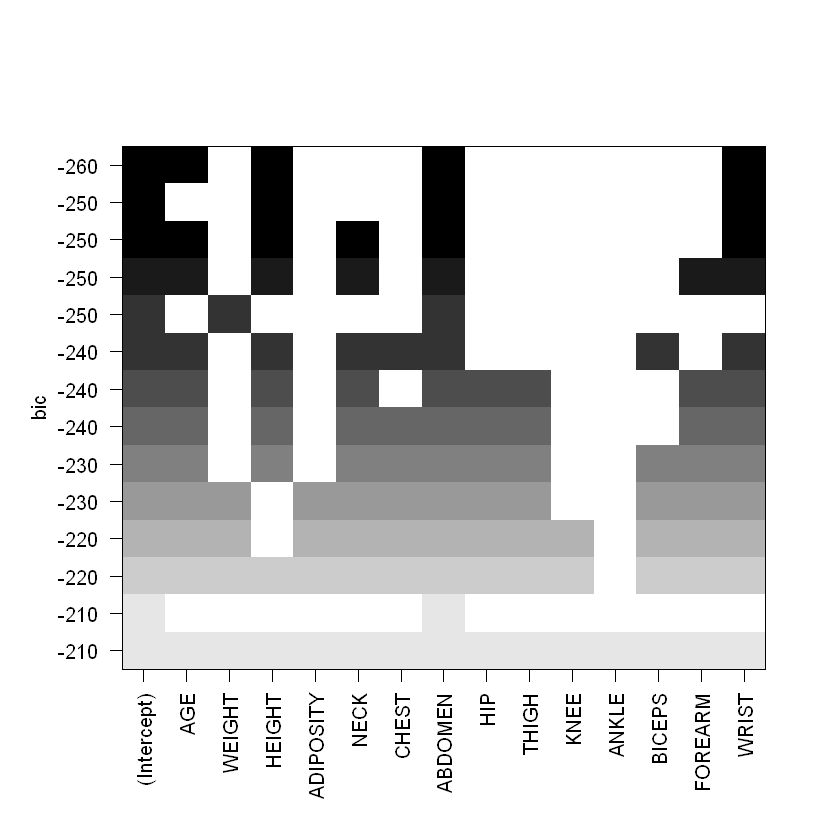

In [9]:
plot(m.regsub, scale = 'bic')

#### Summary

## 插入对比表格

In [35]:
candidate = unique(list(aic.both,aic.back,bic.both,bic.back))

### Models selection

In [14]:
m1 = lm(train$BODYFAT~.,train[,candidate[[1]]])
m2 = lm(train$BODYFAT~.,train[,candidate[[2]]])

In [15]:
model.extract=function(model){
  r = model$residuals
  s = summary(model)
  adjr2 = s$adj.r.squared
  r2 = s$r.squared
  rss = sum(r^2)
  p.value = shapiro.test(r)$p.value
  vif = max(vif(model))
  out = c(r2,adjr2,rss/(length(r)-1),p.value,vif)
  names(out) = c("R-squared","Adjusted R-squared","MSE","p.value","vif.max")
  return(out)
}

In [16]:
comp = rbind(model.extract(m1),model.extract(m2))
rownames(comp) = paste("m",1:2,sep="")
print(comp)

   R-squared Adjusted R-squared      MSE    p.value  vif.max
m1 0.7483912          0.7420694 14.24711 0.03627374 9.854258
m2 0.7384840          0.7345808 14.80810 0.12588880 5.230500


model 1 diagnostic graphics:


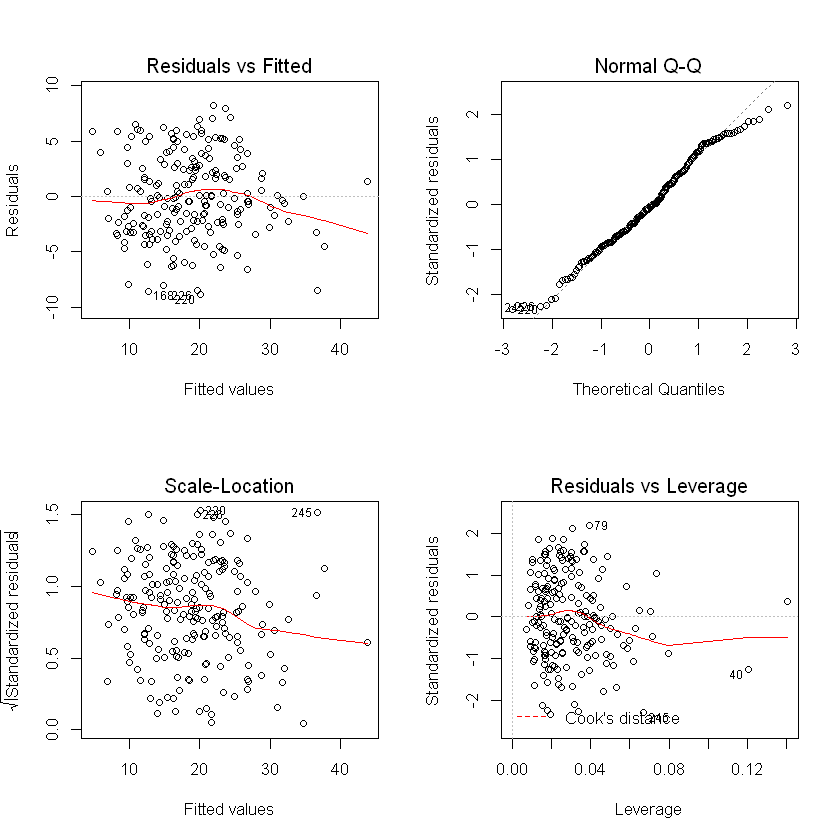

In [17]:
par(mfrow=c(2,2))
cat("model 1 diagnostic graphics:\n")
plot(m1)

model 2 diagnostic graphics:


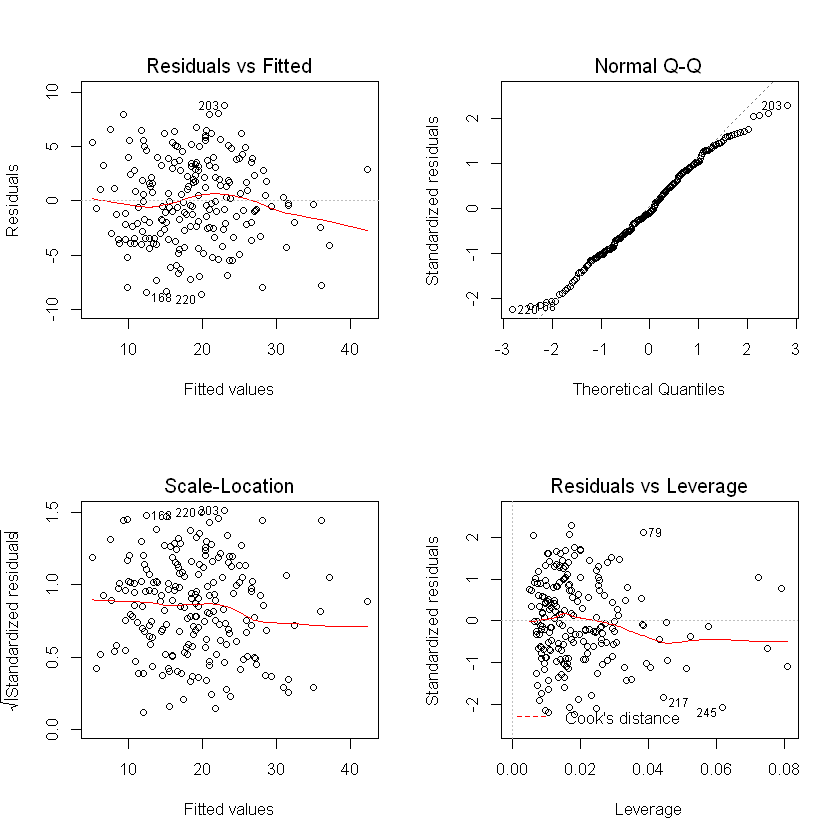

In [18]:
par(mfrow=c(2,2))
cat("model 2 diagnostic graphics:\n")
plot(m2)
par(mfrow=c(1,1))

#### test set

In [19]:
calculate = function(model,ind){
  test.X = test[,ind]
  y = test$BODYFAT
  y.hat = predict.lm(model,test.X)
  r = y-y.hat
  rss = sum(r^2)
  sst = sum((y-mean(y))^2)
  r2 = 1-rss/sst
  adjr2 = 1-(rss/(nrow(test.X)-1))/(sst/(nrow(test.X)-ncol(test.X)-1))
  p.value = shapiro.test(r)$p.value
  outcome = list("R-squared"=r2,
                 "Adjusted R-squared"=adjr2,
                 "p.value"=p.value,
                 "residuals"=r)
  return(outcome)
}

o1 = calculate(m1,candidate[[1]])
o2 = calculate(m2,candidate[[2]])
comp.test = rbind(c(o1$`R-squared`,o1$`Adjusted R-squared`,sum(o1$residuals^2)/(nrow(test)-1),o1$p.value),
                  c(o2$`R-squared`,o2$`Adjusted R-squared`,sum(o2$residuals^2)/(nrow(test)-1),o2$p.value))
colnames(comp.test) = c("R-squared","Adjusted R-squared","MSE","p.value")
rownames(comp.test) = paste("m",1:2,sep="")

In [20]:
cat("models' performances on the training set:\n")
print(comp)
cat("\nmodels' performances on the test set:\n")
print(comp.test)

models' performances on the training set:
   R-squared Adjusted R-squared      MSE    p.value  vif.max
m1 0.7483912          0.7420694 14.24711 0.03627374 9.854258
m2 0.7384840          0.7345808 14.80810 0.12588880 5.230500

models' performances on the test set:
   R-squared Adjusted R-squared      MSE    p.value
m1 0.6874034          0.7255249 19.32334 0.24252198
m2 0.7136825          0.7346326 17.69888 0.08884636


In [34]:
ind = candidate[[2]]
data.select = data[,c("BODYFAT",candidate[[2]])]
m = lm(BODYFAT~.,data.select)
coefficients(summary(m))
cat("Adjusted R-squared:",summary(m)$adj.r.squared)

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),-23.08270803,6.14726113,-3.754958,2.170072e-04
WEIGHT,-0.08728434,0.02202195,-3.963515,9.714444e-05
ABDOMEN,0.88612436,0.05031317,17.612177,2.660634e-45
WRIST,-1.33341041,0.39683825,-3.360085,9.046791e-04


Adjusted R-squared: 0.7325222